TODO:
* Add data and weight initialization randomization
* Add learning rate scheduler
* Give to model two samples: positive and negative at one time
* Try BatchNorm
* Look and analize where models fail

## Description

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective. 
It should be implemented with PyTorch only code, in particular without using other external libraries such as scikit-learn or numpy.

The goal of this project is to implement a deep network such that, given as input a series of 2×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import copy

from networks import NetSimple, NetSiamese
from utils import get_accuracy, grid_search, plot_accuracy_and_loss, test_samples, test_model, plot_test_results

from dlc_practical_prologue import generate_pair_sets

## Data

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate_pair_sets(N) defined in the file
dlc_practical_prologue.py.

In [2]:
N = 1000

In [3]:
train_input, train_class, train_digit, test_input, test_class, test_digit = generate_pair_sets(N)

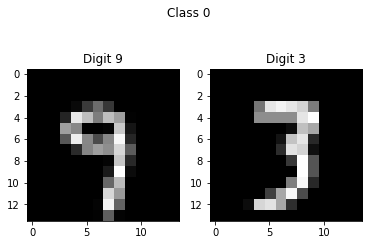

In [4]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_input[0][0], cmap="gray")
axs[0].set_title(f"Digit {train_digit[0][0].item()}")
axs[1].imshow(train_input[0][1], cmap="gray")
axs[1].set_title(f"Digit {train_digit[0][1].item()}")
fig.suptitle(f"Class {train_class[0].item()}")

plt.show()

In [5]:
train_loader = DataLoader(list(zip(train_input, train_class, train_digit)), batch_size=64)
test_loader = DataLoader(list(zip(test_input, test_class, test_digit)), batch_size=64)

## Objective

The goal of the project is to compare different architectures, and assess the performance improvement
that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can
in particular take advantage of the availability of the classes of the two digits in each pair, beside the
Boolean value truly of interest.

In [6]:
cross_entropy = nn.CrossEntropyLoss()
binary_cross_entropy = nn.BCEWithLogitsLoss()

## Model

In [7]:
# Task specific setup
input_channels = 2
output_class_channels = 1
output_digit_channels = 10

### Simple model

First let's implement simple model

In [8]:
net = NetSimple(input_channels, output_class_channels)

In [9]:
def simple_model_criterion(output, target):
    """Loss criterion for simple model: binary cross entropy for class predictons"""
    return binary_cross_entropy(output, target.unsqueeze(1).float())

In [10]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 12, 12]             304
         MaxPool2d-2             [-1, 16, 6, 6]               0
           Dropout-3             [-1, 16, 6, 6]               0
            Conv2d-4             [-1, 32, 4, 4]           4,640
         MaxPool2d-5             [-1, 32, 2, 2]               0
           Dropout-6                  [-1, 128]               0
            Linear-7                  [-1, 100]          12,900
           Dropout-8                  [-1, 100]               0
            Linear-9                    [-1, 1]             101
Total params: 17,945
Trainable params: 17,945
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.07
Estimated Total Size (MB): 0.10
---------------------------------------------

### Model with weight sharing

Since we know that in both channels we have digits, its logical to process them in same way. For that we will use same convolution and fully connected layers. At the end we will also add 2 fully connected layers to actually solve our general task of class prediction.

In [11]:
net = NetSiamese(input_channels, output_class_channels, output_digit_channels)

In [12]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 12, 12]             160
         MaxPool2d-2             [-1, 16, 6, 6]               0
           Dropout-3             [-1, 16, 6, 6]               0
            Conv2d-4             [-1, 32, 4, 4]           4,640
         MaxPool2d-5             [-1, 32, 2, 2]               0
            Conv2d-6           [-1, 16, 12, 12]             160
         MaxPool2d-7             [-1, 16, 6, 6]               0
           Dropout-8             [-1, 16, 6, 6]               0
            Conv2d-9             [-1, 32, 4, 4]           4,640
        MaxPool2d-10             [-1, 32, 2, 2]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                  [-1, 100]          12,900
          Dropout-13                  [-1, 100]               0
           Linear-14                   

In [13]:
def siamese_model_criterion(output, target):
    """Loss criterion for siamese model: binary cross entropy for class predictons"""
    return binary_cross_entropy(output, target.unsqueeze(1).float())

One positive side effect of weight sharing in current setup will be that model will have double more data to train first layers. It happens because we divided each sample in our data and obtained twice more samples.

### Siamese model with auxiliary loss

In these model we will try to train model to not only predict class but also both digits. For that we will use Siamese network from previous step but also add addtional losses on intermediate fully connected layers

In [14]:
def get_auxiliary_loss_model_criterion(lambda_=1):
    
    def auxiliary_loss_model_criterion(output_class, target_class, output_digits, target_digits):
        """Loss criterion for siamese model with auxiliary loss: 
        binary cross entropy for class predictons, cross entropy for both digit predictions"""
        return lambda_ * binary_cross_entropy(output_class, target_class.unsqueeze(1).float()) \
                + cross_entropy(output_digits[0], target_digits[:, 0]) \
                + cross_entropy(output_digits[0], target_digits[:, 1])

    return auxiliary_loss_model_criterion

## Training

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
# device = torch.device("cpu")

In [17]:
def train(train_data_loader, test_data_loader, model, optimizer, criterion, device,
          epochs=10, print_info=False, print_every=5):
    """Trains model"""
    losses = []
    # Accuracy of class prediction
    accuracy_train_class = []
    accuracy_test_class = []
    # Accuracy of digit precition for model with auxiliary loss
    accuracy_train_digit = []
    accuracy_test_digit = []
    # Early stopping (saving the best model among epochs)
    best_model = None
    best_accuracy = 0
    
    model.to(device)
    
    for epoch in range(epochs):
        loss_epoch = 0
        
        # Train
        for (image, target_class, target_digits) in train_data_loader:
            image, target_class, target_digits = image.to(device), target_class.to(device), target_digits.to(device)
            optimizer.zero_grad()
            if model.predicts_digit: # For model with auxiliary loss
                output_class, output_digits = model(image)
                loss = criterion(output_class, target_class, output_digits, target_digits)
            else:
                output_class = model(image)
                loss = criterion(output_class, target_class)
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()
                
        losses.append(loss_epoch)
        
        # Test
        model.eval()
        with torch.no_grad():
            accuracy_train_data = get_accuracy(model, train_data_loader, device,
                                               calculate_accuracy_digit=model.predicts_digit)
            accuracy_test_data = get_accuracy(model, test_data_loader, device,
                                              calculate_accuracy_digit=model.predicts_digit)
            if model.predicts_digit: # For model with auxiliary loss
                acc_train_class, acc_train_digit = accuracy_train_data
                acc_test_class, acc_test_digit = accuracy_test_data

                accuracy_train_digit.append(acc_train_digit)
                accuracy_test_digit.append(acc_test_digit)
            else:
                acc_train_class = accuracy_train_data
                acc_test_class = accuracy_test_data

            accuracy_train_class.append(acc_train_class)
            accuracy_test_class.append(acc_test_class)
    
        if accuracy_test_class[-1] > best_accuracy:
            best_model = copy.deepcopy(model)
            best_accuracy = accuracy_test_class[-1]
            
        if print_info and (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{epochs}, loss {losses[-1]:0.4f},",
                  f"class train/test accuracy: {accuracy_train_class[-1]}/{accuracy_test_class[-1]}",
                  f", digit train/test accuracy: {accuracy_train_digit[-1]}/{accuracy_test_digit[-1]}"
                  if accuracy_train_digit else "")
            
    if print_info:
        print(f"Achieved accuracy: {best_accuracy}")
    return best_model, [accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit], losses

#### Simple net

In [18]:
epochs_grid_search = 20
epochs_train = 30

In [19]:
lr_simple_net = 0.01
reg_simple_net = 0.25

In [20]:
model_class = NetSimple
model_params = {"input_channels": input_channels, 
                "output_channels": output_class_channels,
                "activation": "leakyrelu"}
criterion = simple_model_criterion

lr_simple_net, reg_simple_net = grid_search([0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                              [0.25, 0.1, 0.05, 0.01], # Regularizations
                                              train, train_loader, test_loader, device, 
                                              model_class, model_params, criterion, 
                                              epochs=epochs_grid_search, print_info=True)

Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.808
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.779
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.773
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.779
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.800
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.767
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.767
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.768
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.787
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.794
Learning rate: 0.0010, Regularization: 0.05, Test Accuracy: 0.775
Learning rate: 0.0010, Regularization: 0.01, Test Accuracy: 0.764
Learning rate: 0.0005, Regularization: 0.25, Test Accuracy: 0.787
Learning rate: 0.0005, Regularization: 0.10, Test Accuracy: 0.790
Learning rate: 0.0005, Regularization: 0.05, Test Accuracy: 0.756
Learning r

In [21]:
net_simple = NetSimple(input_channels, output_class_channels, activation="leakyrelu")
optimizer = optim.Adam(net_simple.parameters(), lr=lr_simple_net, weight_decay=reg_simple_net)
criterion = simple_model_criterion

net_simple, accuracies, losses = train(train_loader, test_loader,
                                       net_simple,
                                       optimizer, 
                                       criterion,
                                       device=device,
                                       epochs=epochs_train, print_info=True)

accuracy_train_class, accuracy_test_class, _, _ = accuracies

Epoch 5/30, loss 8.0286, class train/test accuracy: 0.786/0.746 
Epoch 10/30, loss 7.1691, class train/test accuracy: 0.758/0.729 
Epoch 15/30, loss 6.4248, class train/test accuracy: 0.85/0.776 
Epoch 20/30, loss 6.3257, class train/test accuracy: 0.867/0.778 
Epoch 25/30, loss 5.3642, class train/test accuracy: 0.856/0.786 
Epoch 30/30, loss 5.1353, class train/test accuracy: 0.889/0.786 
Achieved accuracy: 0.786


In [22]:
net_simple_filename = "net_simple.ckpt"
torch.save(net_simple.state_dict(), net_simple_filename)

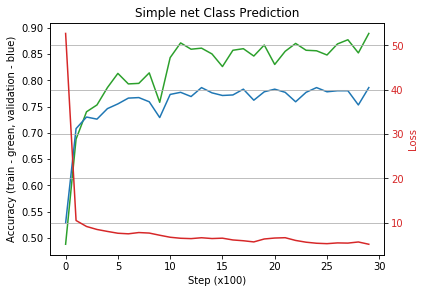

In [23]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="Simple net Class Prediction") # tanh

#### Siamese network

In [24]:
epochs_grid_search = 20
epochs_train = 30

In [25]:
lr_siamese_net = 0.001
reg_siamese_net = 0.01

In [26]:
model_class = NetSiamese
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels,
                "activation": "leakyrelu"}
criterion = siamese_model_criterion

lr_siamese_net, reg_siamese_net = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                              [0.25, 0.1, 0.05, 0.01], # Regularizations
                                              train, train_loader, test_loader, device, 
                                              model_class, model_params, criterion, 
                                              epochs=epochs_grid_search, print_info=True)

Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.808
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.810
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.797
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.828
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.526
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.837
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.843
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.864
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.815
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.846
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.841
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.861
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.845
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.879
Learning rate: 0.0010, Regularization: 0.05, Test Accuracy: 0.867
Learning r

In [27]:
net_siamese = NetSiamese(input_channels, output_class_channels, output_digit_channels, activation="leakyrelu")
optimizer = optim.Adam(net_siamese.parameters(), lr=lr_siamese_net, weight_decay=reg_siamese_net)
criterion = siamese_model_criterion

net_siamese, accuracies, losses = train(train_loader, test_loader,
                                           net_siamese,
                                           optimizer, 
                                           criterion,
                                           device=device,
                                           epochs=epochs_train, print_info=True)

accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies

Epoch 5/30, loss 6.9453, class train/test accuracy: 0.822/0.815 
Epoch 10/30, loss 3.8620, class train/test accuracy: 0.929/0.848 
Epoch 15/30, loss 2.1688, class train/test accuracy: 0.982/0.85 
Epoch 20/30, loss 1.1744, class train/test accuracy: 0.996/0.851 
Epoch 25/30, loss 0.9287, class train/test accuracy: 0.996/0.854 
Epoch 30/30, loss 1.1466, class train/test accuracy: 0.973/0.853 
Achieved accuracy: 0.857


In [28]:
siamese_net_filename = "net_siamese_loss.ckpt"
torch.save(net_siamese.state_dict(), siamese_net_filename)

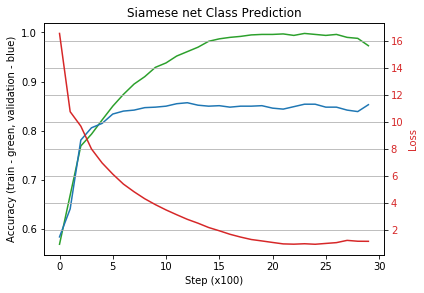

In [29]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="Siamese net Class Prediction")

#### Auxiliary loss

In [30]:
epochs_grid_search = 30
epochs_train = 30

In [31]:
best_lambda = 5

In [32]:
lr_auxiliary_loss = 0.01
reg_auxiliary_loss = 0.05

In [33]:
model_class = NetSiamese
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels,
                "activation": "leakyrelu",
                "auxiliary_loss": True}
criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

lr_auxiliary_loss, reg_auxiliary_loss = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                                      [0.25, 0.1, 0.05, 0.01], # Regularizations
                                                      train, train_loader, test_loader, device, 
                                                      model_class, model_params, criterion, 
                                                      epochs=epochs_grid_search, print_info=True)

Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.843
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.846
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.831
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.814
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.858
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.865
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.844
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.847
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.868
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.845
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.864
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.849
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.848
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.856
Learning rate: 0.0010, Regularization: 0.05, Test Accuracy: 0.828
Learning r

In [34]:
net_auxiliary_loss = NetSiamese(input_channels, output_class_channels, output_digit_channels, 
                                activation="leakyrelu", auxiliary_loss=True)
optimizer = optim.Adam(net_auxiliary_loss.parameters(), lr=lr_auxiliary_loss, weight_decay=reg_auxiliary_loss)
criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

net_auxiliary_loss, accuracies, losses = train(train_loader, test_loader,
                                               net_auxiliary_loss,
                                               optimizer, 
                                               criterion,
                                               device=device,
                                               epochs=epochs_train, print_info=True)

accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies

Epoch 5/30, loss 117.1072, class train/test accuracy: 0.721/0.72 , digit train/test accuracy: 0.5795/0.554
Epoch 10/30, loss 89.8105, class train/test accuracy: 0.855/0.82 , digit train/test accuracy: 0.7/0.6975
Epoch 15/30, loss 79.7602, class train/test accuracy: 0.901/0.843 , digit train/test accuracy: 0.807/0.7735
Epoch 20/30, loss 74.9845, class train/test accuracy: 0.932/0.845 , digit train/test accuracy: 0.835/0.794
Epoch 25/30, loss 70.6594, class train/test accuracy: 0.942/0.86 , digit train/test accuracy: 0.801/0.7715
Epoch 30/30, loss 71.6474, class train/test accuracy: 0.952/0.847 , digit train/test accuracy: 0.845/0.8105
Achieved accuracy: 0.866


In [35]:
net_auxiliary_loss_filename = "net_auxiliary_loss.ckpt"
torch.save(net_auxiliary_loss.state_dict(), net_auxiliary_loss_filename)

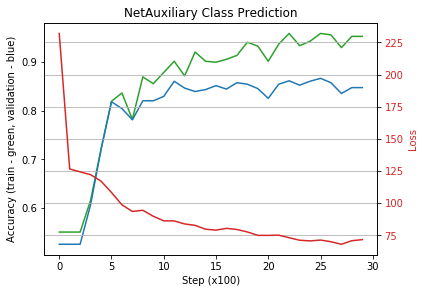

In [36]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="NetAuxiliary Class Prediction")

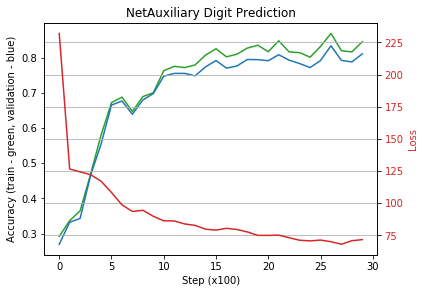

In [37]:
plot_accuracy_and_loss(accuracy_train_digit, accuracy_test_digit, losses, title="NetAuxiliary Digit Prediction")

### Test

#### Simple net

In [38]:
checkpoint = torch.load(net_simple_filename)
net_simple = NetSimple(input_channels, output_class_channels)
net_simple.load_state_dict(checkpoint)
# net_simple.to(device)

<All keys matched successfully>

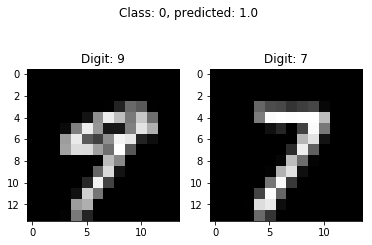

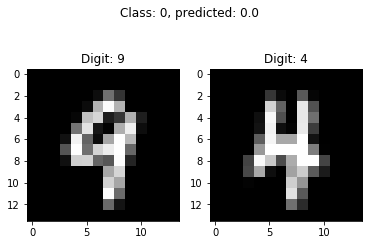

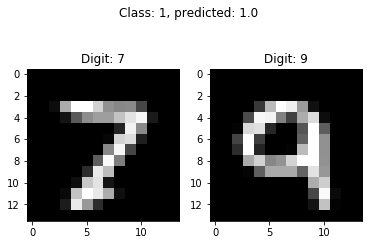

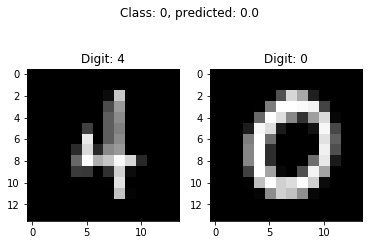

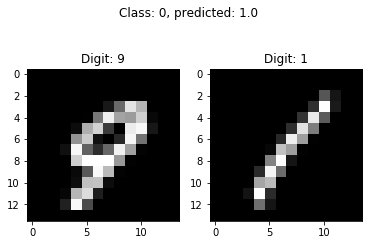

In [39]:
test_samples(net_simple, test_input, test_class, test_digit)

#### Weight sharing (Siamese network)

In [40]:
checkpoint = torch.load(siamese_net_filename)
net_siamese = NetSiamese(input_channels, output_class_channels, output_digit_channels)
net_siamese.load_state_dict(checkpoint)
# net_simple.to(device)

<All keys matched successfully>

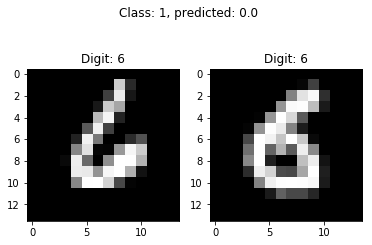

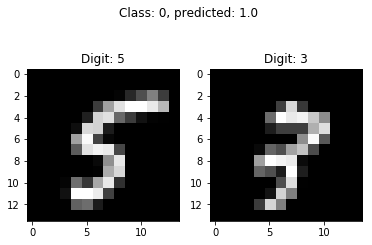

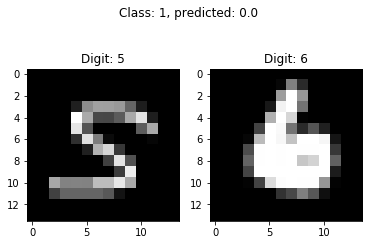

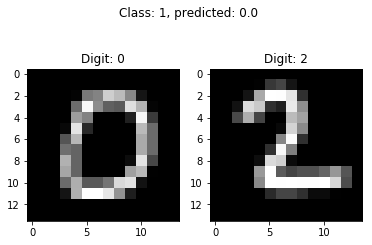

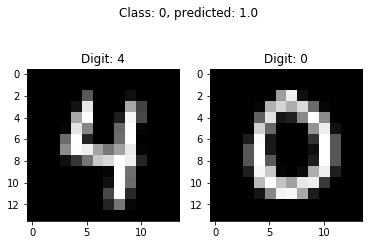

In [41]:
test_samples(net_siamese, test_input, test_class, test_digit)

#### Auxiliary loss

In [42]:
checkpoint = torch.load(net_auxiliary_loss_filename)
net_auxiliary_loss = NetSiamese(input_channels, output_class_channels, output_digit_channels, auxiliary_loss=True)
net_auxiliary_loss.load_state_dict(checkpoint)
# net_simple.to(device)

<All keys matched successfully>

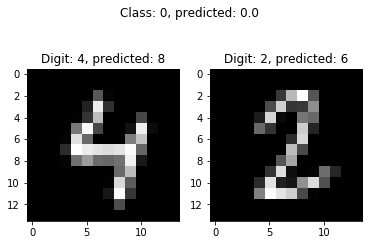

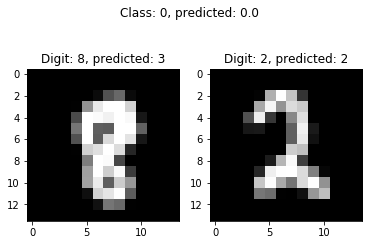

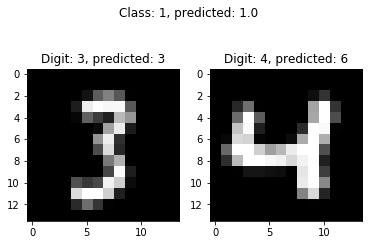

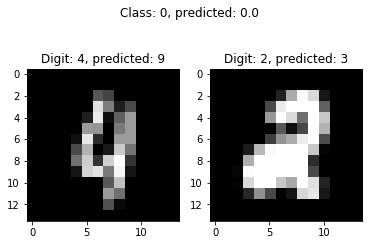

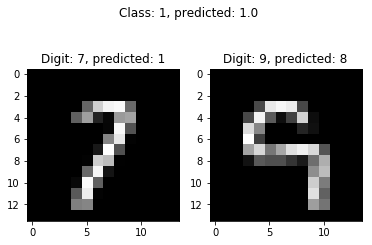

In [43]:
test_samples(net_auxiliary_loss, test_input, test_class, test_digit)

## Experiments

All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000
parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error
rate.

Performance estimates provided in your report should be estimated through 10+ rounds for each
architecture, where both data and weight initialization are randomized, and you should provide estimates
of standard deviations.

In [44]:
nb_tests = 20
epochs_train = 30

#### Simple net

In [51]:
model_class = NetSimple
model_params = {"input_channels": input_channels, 
                "output_channels": output_class_channels,
                "activation": "leakyrelu"}
criterion = simple_model_criterion

accuracy_values, loss_values = test_model(train, train_loader, test_loader, device,
                                            model_class, model_params, criterion, lr_simple_net, reg_simple_net,
                                            nb_tests=nb_tests, epochs=epochs_train)

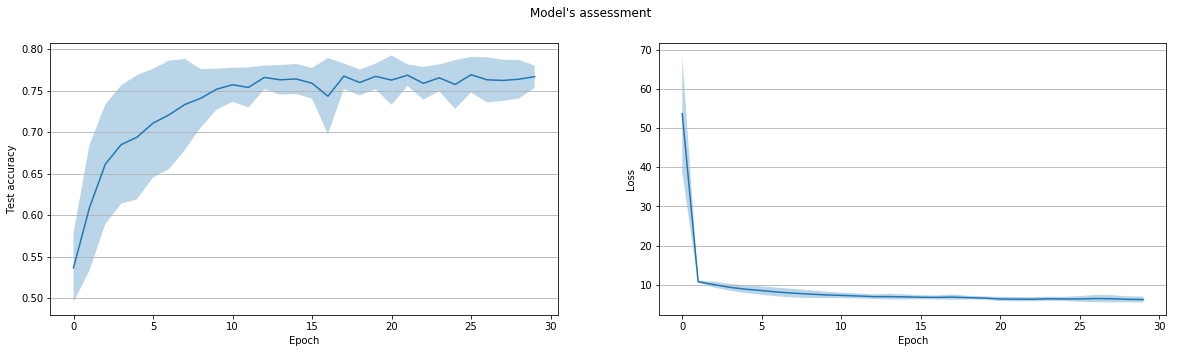

In [53]:
plot_test_results(accuracy_values, loss_values, title="Simple net")

#### Siamese Net 

Let's try different versions of siamese network

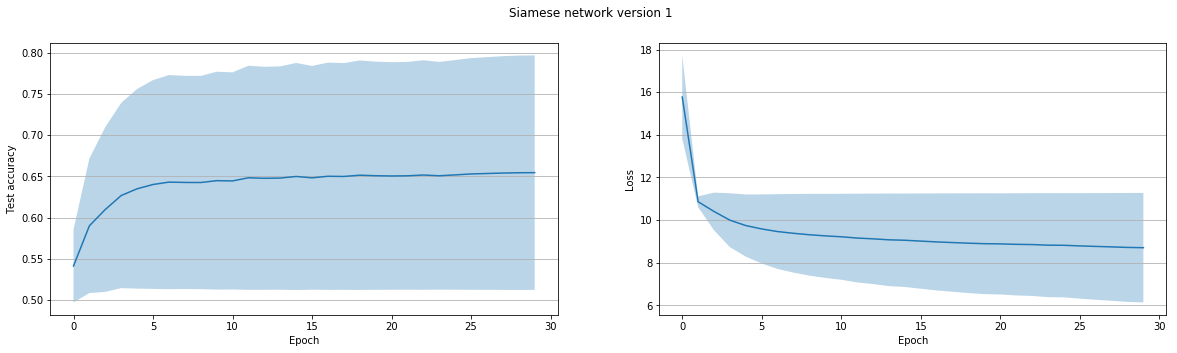

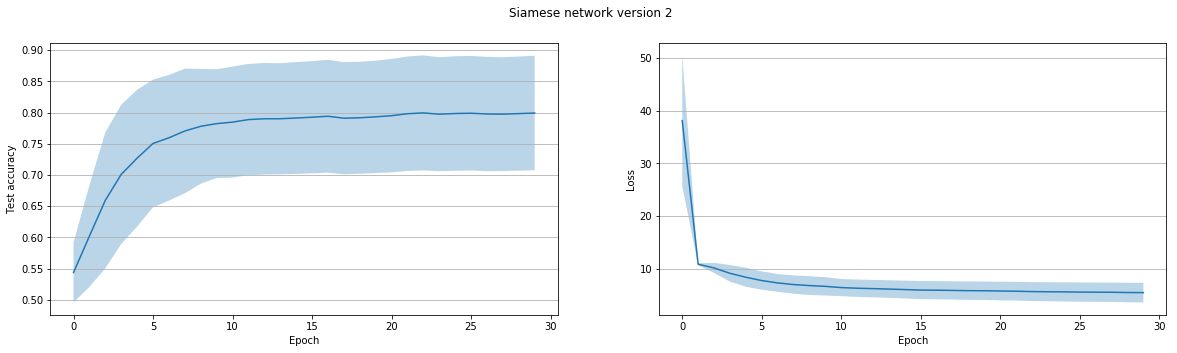

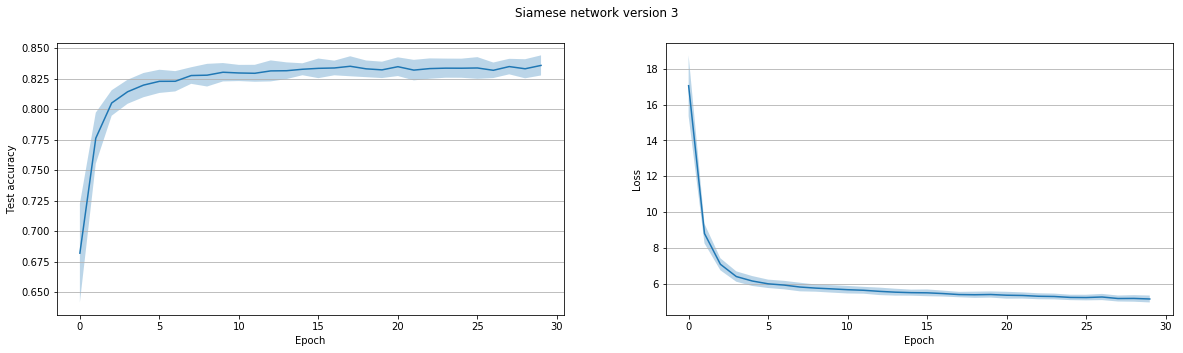

In [47]:
for ver in [1, 2, 3]:
    model_class = NetSiamese
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "version": ver}
    criterion = siamese_model_criterion
    
    accuracy_values, loss_values = test_model(train, train_loader, test_loader, device,
                                                model_class, model_params, criterion, lr_auxiliary_loss, reg_auxiliary_loss,
                                                nb_tests=nb_tests, epochs=epochs_train)
    
    plot_test_results(accuracy_values, loss_values, title=f"Siamese network version {ver}")

#### Net with AuxiliaryLoss

Let's try different versions of siamese network

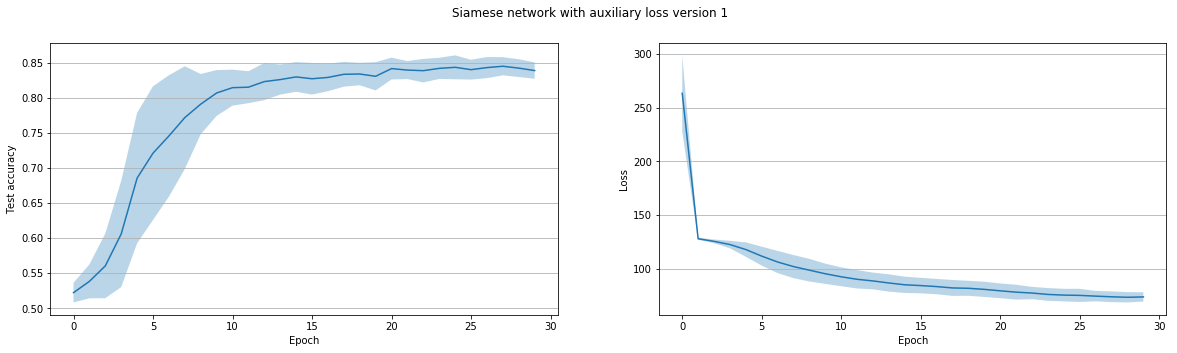

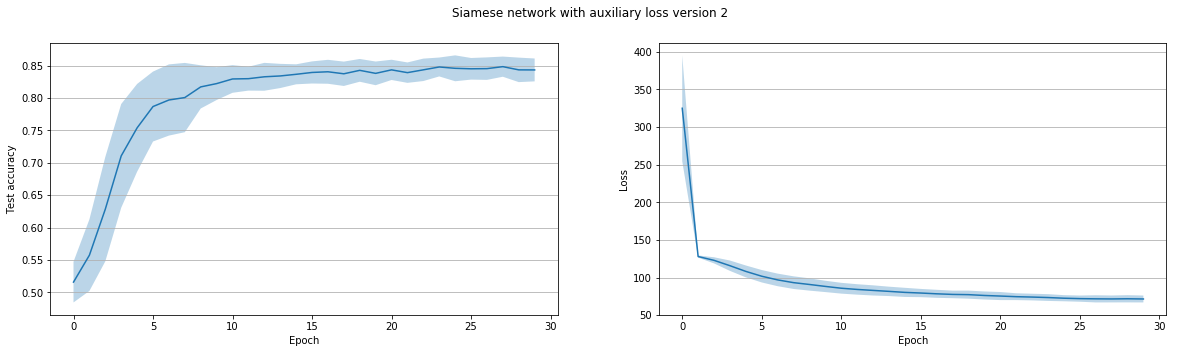

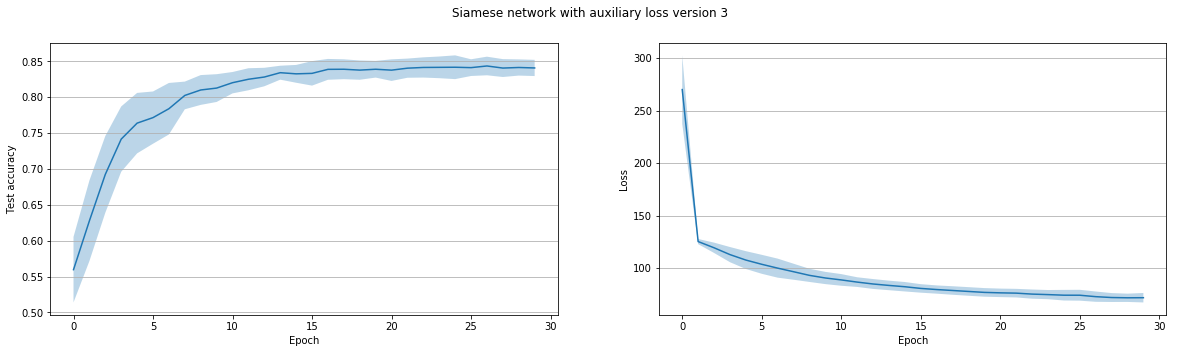

In [48]:
for ver in [1, 2, 3]:
    model_class = NetSiamese
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "version": ver,
                    "auxiliary_loss": True}
    criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

    accuracy_values, loss_values = test_model(train, train_loader, test_loader, device,
                                                model_class, model_params, criterion, lr_auxiliary_loss, reg_auxiliary_loss,
                                                nb_tests=nb_tests, epochs=epochs_train)
    
    plot_test_results(accuracy_values, loss_values, title=f"Siamese network with auxiliary loss version {ver}")

We see that simple net model have accuracy below 80%. Then, turning to siamese arhictecture we increase accuracy to level between 82.5% and 85%. Finnaly, after adding additional loss for sample's both digit prediction we get accuracy approximately 85%.